<a href="https://colab.research.google.com/github/realyou0312/DataAnalysis/blob/main/0506_%EC%95%99%EC%83%81%EB%B8%94_%EC%8B%9C%EB%8F%84_%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0_%EC%88%98%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, log_loss, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

from sklearn.cluster import KMeans
# from catboost import CatBoostClassifier, Pool

# import optuna
# from optuna import Trial
# from optuna.samplers import TPESampler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/DACON_Credit/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

In [5]:
train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
train.fillna('NaN', inplace=True) 

test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test.fillna('NaN', inplace=True)


In [6]:
train["DAYS_EMPLOYED"] = train["DAYS_EMPLOYED"].map(lambda x: 0 if x > 0 else x)
test["DAYS_EMPLOYED"] = test["DAYS_EMPLOYED"].map(lambda x: 0 if x > 0 else x)

In [7]:
train = train[(train['family_size'] <= 7)]
# train.set_index('index', inplace=True)
train = train.reset_index(drop=True)

In [8]:
# train_corr = train.corr()
# ax = plt.subplots(figsize=(30, 25))
# ax = sns.heatmap(train_corr, center=0, annot = True, linewidths=.5)

### 음수값 -> 양수 변환

In [9]:
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

In [ ]:
# fig, axes = plt.subplots(1, 3, figsize=(12, 4))
# train['begin_month'][train['credit']==0].hist(bins=25, ax=axes[0])
# train['begin_month'][train['credit']==1].hist(bins=25, ax=axes[1])
# train['begin_month'][train['credit']==2].hist(bins=25, ax=axes[2])


In [ ]:
# train['begin_month_level'] = pd.qcut(train['begin_month'], q=8, labels=['A','B','C','D','E','F','G','H'])
# test['begin_month_level'] = pd.qcut(test['begin_month'], q=8, labels=['A','B','C','D','E','F','G','H'])
# train['begin_month_level'] = train['begin_month_level'].astype('object')

### Feature Engineering

In [10]:
for df in [train,test]:
    # df['DAYS_BIRTH_DAYS_EMPLOYED_ratio'] = np.floor(df['DAYS_EMPLOYED'] / df['DAYS_BIRTH'])
    # df['income_total_DAYS_BIRTH_ratio'] = np.floor(df['income_total'] / df['DAYS_BIRTH'])
    #df['income_total_DAYS_EMPLOYED_ratio'] = np.floor(df['income_total'] / df['DAYS_EMPLOYED'])
    #df['income_total_begin_month_ratio'] = np.floor(df['begin_month'] / df['DAYS_EMPLOYED'])
    #df['parents'] = df['family_size'] - df['child_num']
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_workingday_ratio'] = df['income_total'] / df['before_EMPLOYED']
    
    df["DAYS_BIRTH_m"] = np.floor(df["DAYS_BIRTH"] / 30) - ((np.floor(df["DAYS_BIRTH"] / 30) / 12).astype(int) * 12)
    df["DAYS_BIRTH_w"] = np.floor(df["DAYS_BIRTH"] / 7) - ((np.floor(df["DAYS_BIRTH"] / 7) / 4).astype(int) * 4)
    df["Age"] = df["DAYS_BIRTH"] // 365
    
    df["before_EMPLOYED_m"] = np.floor(df["before_EMPLOYED"] / 30) - ((np.floor(df["before_EMPLOYED"] / 30) / 12).astype(int) * 12)
    df["before_EMPLOYED_w"] = np.floor(df["before_EMPLOYED"] / 7) - ((np.floor(df["before_EMPLOYED"] / 7) / 4).astype(int) * 4)
    
    df["DAYS_EMPLOYED_m"] = np.floor(df["DAYS_EMPLOYED"] / 30) - ((np.floor(df["DAYS_EMPLOYED"] / 30) / 12).astype(int) * 12)
    df["DAYS_EMPLOYED_w"] = np.floor(df["DAYS_EMPLOYED"] / 7) - ((np.floor(df["DAYS_EMPLOYED"] / 7) / 4).astype(int) * 4)
    df["EMPLOYED"] = df["DAYS_EMPLOYED"] // 365
#     df['EMPLOYED_begin_month_ratio'] = np.floor(df['begin_month'] / (df["DAYS_EMPLOYED"]) / 30)

    #df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
    df['income_mean'] = df['income_total'] / df['family_size']
    
    df['GCR'] = (df['gender'].astype(str) + "_" + df['car'].astype(str) + "_" + df['reality'].astype(str))


In [ ]:
# for df in [train,test]:
#     df["contact"] = df["email"].astype(str)+df["phone"].astype(str)+ df["work_phone"].astype(str)
#     df["info"] = df["gender"].astype(str)+df["occyp_type"].astype(str)+ df["edu_type"].astype(str)
# ID_columns = ["contact", "info"]
# for feat in ID_columns:
#     order= train[feat][train["credit"]==2].value_counts(normalize= True, sort= True).index
#     mapping = {}
#     for index, value in enumerate(order):
#         mapping[value]= index
#     train[feat] = train[feat].map(mapping)
#     test[feat] = test[feat].map(mapping)

In [ ]:
# for df in [train,test]:
    
#    df["contact"] = df["email"].astype(str) + '-' + df["phone"].astype(str) + '-' + df["work_phone"].astype(str)


In [ ]:
# open_month = pd.DataFrame(train.groupby('ID')['begin_month'].min(), index=train.groupby('ID')['begin_month'].min().index)
# open_month= open_month.astype('int')
# open_month.columns = ['open_month']
# om_dict = open_month.open_month.to_dict()

# train['open_month'] = train["ID"]
# train['open_month'] = train['open_month'].map(om_dict)

In [ ]:
# open_month = pd.DataFrame(test.groupby('ID')['begin_month'].min(), index=test.groupby('ID')['begin_month'].min().index)
# open_month= open_month.astype('int')
# open_month.columns = ['open_month']
# om_dict = open_month.open_month.to_dict()

# test['open_month'] = test["ID"]
# test['open_month'] = test['open_month'].map(om_dict)

In [ ]:
#train.sort_values(by=['index'], axis=0, inplace=True, ignore_index=True)
#test.sort_values(by=['index'], axis=0, inplace=True, ignore_index=True)

In [ ]:
#train.drop(['ID'], axis=1, inplace=True)
#test.drop(['ID'], axis=1, inplace=True)

In [ ]:
#new_data=pd.DataFrame(train.groupby(["ID"])["begin_month"].agg(min))
#new_data

### 사용한, 중요도 낮은 컬럼 삭제

In [11]:
del_cols = [
     'gender',
     'car',
     'reality',
    'child_num',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
    'email',
#    'parents',
#     'phone',
#     'work_phone'
#     'before_EMPLOYED',
#     'ability',
    #'income_type', 'edu_type', 'family_size', 'phone', 'house_type', 'work_phone', 
#     'G_C_R'

]

train.drop(del_cols, axis=1, inplace=True)
test.drop(del_cols, axis=1, inplace=True)

In [12]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
# numerical_feats.remove('ID')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

total_feats = numerical_feats + categorical_feats

Number of Numerical features:  16
Number of Categorical features:  6


## LabelEncoding, Scaling

In [ ]:
categorical_feats

['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'GCR']

In [ ]:
# for df in [train,test]:
# #     df['gender'] = df.groupby(['gender'])['index'].transform('count')
# #     df['car'] = df.groupby(['car'])['index'].transform('count')
# #     df['reality'] = df.groupby(['reality'])['index'].transform('count')
# #     df['phone'] = df.groupby(['phone'])['index'].transform('count')
# #     df['work_phone'] = df.groupby(['work_phone'])['index'].transform('count')
# #     df['email'] = df.groupby(['email'])['index'].transform('count')
#     df['ID'] = df.groupby(['ID'])['index'].transform('count')
#     df['GCR'] = df.groupby(['GCR'])['index'].transform('count')
#     df['income_type'] = df.groupby(['income_type'])['index'].transform('count')
#     df['edu_type'] = df.groupby(['edu_type'])['index'].transform('count')
#     df['family_type'] = df.groupby(['family_type'])['index'].transform('count')
#     df['house_type'] = df.groupby(['house_type'])['index'].transform('count')
#     df['occyp_type'] = df.groupby(['occyp_type'])['index'].transform('count')


In [13]:
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])
    


In [14]:
for feat in categorical_feats:
    encoder = LabelEncoder()
    train[feat] = encoder.fit_transform(train[feat])
    test[feat] = encoder.transform(test[feat])

In [15]:
kmeans_train = train.drop(["credit"], axis=1)
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train["kmeans_clusters"] = kmeans.predict(kmeans_train)
test["kmeans_clusters"] = kmeans.predict(test)

In [16]:
#numerical_feats.remove('begin_month')
#numerical_feats.remove('age_groups')
numerical_feats.remove('income_total')
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])


## Modeling

In [28]:
n_est = 2000
seed = 42
n_fold = 10
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [19]:
lgb_params = {
                    'objective':'multiclass',
                    'num_class': n_class,
                    'boosting_type':'gbdt',
                    'metric':'multi_logloss',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 127,
                    'max_depth':20,
                    'tree_learner':'serial',
                    "min_child_weight": 0.01,
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.5,
                    'n_estimators':n_est,
                    'max_bin':800,
                    'verbose':-1,
                    'seed': seed,
                    #'early_stopping_rounds':300, 
                }


### Model : LGBM

In [ ]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))


pred = np.zeros((X.shape[0], n_class), dtype=float)
pred_test = np.zeros((X_test.shape[0], n_class), dtype=float)
for fold in range(n_fold):
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    model_lgbm = LGBMClassifier(**lgb_params)
    model_lgbm.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            early_stopping_rounds=100,
            verbose=100,)
    pred[valid_idx] = model_lgbm.predict_proba(X_valid)
    pred_test += model_lgbm.predict_proba(X_test) / n_fold
    
log_score = log_loss(y, pred)
print(f'\tCV Log Loss: {log_loss(y, pred):.6f}')

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.758333	valid_1's multi_logloss: 0.797658
[200]	training's multi_logloss: 0.687374	valid_1's multi_logloss: 0.75912
[300]	training's multi_logloss: 0.636284	valid_1's multi_logloss: 0.735792
[400]	training's multi_logloss: 0.595966	valid_1's multi_logloss: 0.720939
[500]	training's multi_logloss: 0.56235	valid_1's multi_logloss: 0.709229
[600]	training's multi_logloss: 0.533477	valid_1's multi_logloss: 0.700563
[700]	training's multi_logloss: 0.508049	valid_1's multi_logloss: 0.693693
[800]	training's multi_logloss: 0.485615	valid_1's multi_logloss: 0.688624
[900]	training's multi_logloss: 0.465259	valid_1's multi_logloss: 0.68557
[1000]	training's multi_logloss: 0.446695	valid_1's multi_logloss: 0.682764
[1100]	training's multi_logloss: 0.42961	valid_1's multi_logloss: 0.680598
[1200]	training's multi_logloss: 0.413818	valid_1's multi_logloss: 0.678938
[1300]	training's multi_logloss: 0.399

TypeError: ignored

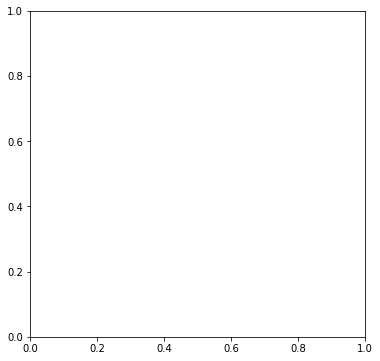

In [35]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline


f, ax = plt.subplots(figsize=(6, 6))
plot_importance(model_lgbm, ax=ax, max_num_features=len(X_test.columns))
#plt.savefig('Feature importance_0505다시시도 기본판.png')

### Model : RF

In [29]:
rf_params = {
        "criterion": "gini",
        "n_estimators": 1500,
        "min_samples_split": 10,
        "min_samples_leaf": 1,
        "max_features": "auto",
        "oob_score": True,
        "random_state": seed,
        "n_jobs": -1,
}

In [30]:
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
rf_oof = np.zeros((X.shape[0], 3))
rf_preds = np.zeros((X_test.shape[0], 3))

for fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    print(f"============ Fold {fold} ============\n")
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    model_rf = RandomForestClassifier(**rf_params)
    model_rf.fit(
            X_train,
            y_train,
        )

    rf_oof[valid_idx] = model_rf.predict_proba(X_valid)
    rf_preds += model_rf.predict_proba(X_test) / n_fold
    print(f"CV Log Loss: {log_loss(y_valid, rf_oof[valid_idx]):.5f}")

log_score = log_loss(y, rf_oof)
print(f"Log Loss Score: {log_score:.5f}")

============ Fold 0 ============

CV Log Loss: 0.67451
============ Fold 1 ============

CV Log Loss: 0.67763
============ Fold 2 ============

CV Log Loss: 0.67997
============ Fold 3 ============

CV Log Loss: 0.69108
============ Fold 4 ============

CV Log Loss: 0.67590
============ Fold 5 ============

CV Log Loss: 0.70523
============ Fold 6 ============

CV Log Loss: 0.68286
============ Fold 7 ============

CV Log Loss: 0.68674
============ Fold 8 ============

CV Log Loss: 0.68930
============ Fold 9 ============

CV Log Loss: 0.69376
Log Loss Score: 0.68570


### Model : XGB

In [37]:
xgb_params = {
        "random_state": seed,
        "n_estimators": 3000,
        "objective": "multi:softmax",
        "eval_metric": "mlogloss",
        "eta": 0.01,
        "reg_alpha": 3e-5,
        "reg_lambda": 9e-2,
        "max_depth": 20,
        "max_leaves": 127,
        "colsample_bytree": 1.0,
        "subsample": 1.0,
        "min_child_weight": 5,
        "gamma": 0.5,
}

In [38]:
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
xgb_oof = np.zeros((X.shape[0], 3))
xgb_preds = np.zeros((X_test.shape[0], 3))

for fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    print(f"============ Fold {fold} ============\n")
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model_xgb = XGBClassifier(**xgb_params)
    model_xgb.fit(
            X_train,
            y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            early_stopping_rounds=100,
            verbose=100,
    )

    xgb_oof[valid_idx] = model_xgb.predict_proba(X_valid)
    xgb_preds += model_xgb.predict_proba(X_test) / n_fold

log_score = log_loss(y, xgb_oof)
print(f"Log Loss Score: {log_score:.5f}")

============ Fold 0 ============

[0]	validation_0-mlogloss:1.0263	validation_1-mlogloss:1.04237
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 100 rounds.
[100]	validation_0-mlogloss:0.264236	validation_1-mlogloss:0.707256
Stopping. Best iteration:
[41]	validation_0-mlogloss:0.374036	validation_1-mlogloss:0.694775

============ Fold 1 ============

[0]	validation_0-mlogloss:1.02794	validation_1-mlogloss:1.04495
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 100 rounds.
[100]	validation_0-mlogloss:0.257012	validation_1-mlogloss:0.736344
Stopping. Best iteration:
[36]	validation_0-mlogloss:0.381015	validation_1-mlogloss:0.717071

============ Fold 2 ============

[0]	validation_0-mlogloss:1.02871	validation_1-mlogloss:1.04439
Multiple eval metrics have been passed: 'valida

### Model : Catboost

In [ ]:
cat_params = {
        "l2_leaf_reg": 0.08,
        "max_depth": 10,
        "bagging_temperature": 1,
        "min_data_in_leaf": 72,
        "max_bin": 300,
        "random_state": seed,
        "eval_metric": "MultiClass",
        "loss_function": "MultiClass",
        "learning_rate": 0.01,
        "od_type": "Iter",
        "od_wait": 500,
        "n_estimators": 2000,
        "cat_features": [
            "income_type",
            "edu_type",
            "family_type",
            "house_type",
            "occyp_type",
            "GCR",
        ],
    }

In [ ]:
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
cat_oof = np.zeros((X.shape[0], 3))
cat_preds = np.zeros((X_test.shape[0], 3))
cat_cols = [
        "income_type",
        "edu_type",
        "family_type",
        "house_type",
        "occyp_type",
        "GCR",
]

for fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    print(f"============ Fold {fold} ============\n")
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

    model_cat = CatBoostClassifier(**cat_params)

    model_cat.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        use_best_model=True,
        early_stopping_rounds=100,
        verbose=100,
    )

    cat_oof[valid_idx] = model_cat.predict_proba(X_valid)
    cat_preds += model_cat.predict_proba(X_test) / n_fold

log_score = log_loss(y, cat_oof)
print(f"Log Loss Score: {log_score:.5f}\n")

============ Fold 0 ============

0:	learn: 1.0922848	test: 1.0922848	test1: 1.0925674	best: 1.0925674 (0)	total: 604ms	remaining: 20m 7s
100:	learn: 0.8468280	test: 0.8485395	test1: 0.8505082	best: 0.8505082 (100)	total: 37.1s	remaining: 11m 37s
200:	learn: 0.7972349	test: 0.8022626	test1: 0.8092762	best: 0.8092762 (200)	total: 1m 20s	remaining: 12m 3s
300:	learn: 0.7667936	test: 0.7795865	test1: 0.7963925	best: 0.7963925 (300)	total: 2m 22s	remaining: 13m 23s
400:	learn: 0.7382263	test: 0.7599362	test1: 0.7866394	best: 0.7866394 (400)	total: 3m 28s	remaining: 13m 53s
500:	learn: 0.7137022	test: 0.7441323	test1: 0.7797359	best: 0.7797359 (500)	total: 4m 35s	remaining: 13m 44s
600:	learn: 0.6876843	test: 0.7268937	test1: 0.7723448	best: 0.7723448 (600)	total: 5m 43s	remaining: 13m 19s
700:	learn: 0.6654265	test: 0.7127062	test1: 0.7669628	best: 0.7669628 (700)	total: 6m 48s	remaining: 12m 37s
800:	learn: 0.6425336	test: 0.6986527	test1: 0.7614171	best: 0.7614171 (800)	total: 7m 55s	rem

900:	learn: 0.6179850	test: 0.6706673	test1: 0.7564898	best: 0.7564898 (900)	total: 9m 21s	remaining: 11m 24s
1000:	learn: 0.5949340	test: 0.6534986	test1: 0.7502196	best: 0.7502196 (1000)	total: 10m 35s	remaining: 10m 34s
1100:	learn: 0.5690500	test: 0.6310175	test1: 0.7431042	best: 0.7431042 (1100)	total: 11m 43s	remaining: 9m 34s
1200:	learn: 0.5440280	test: 0.6084217	test1: 0.7362105	best: 0.7362105 (1200)	total: 12m 50s	remaining: 8m 32s
1300:	learn: 0.5200900	test: 0.5859605	test1: 0.7304804	best: 0.7304804 (1300)	total: 13m 55s	remaining: 7m 28s
1400:	learn: 0.4978511	test: 0.5649077	test1: 0.7257539	best: 0.7257539 (1400)	total: 15m	remaining: 6m 24s
1500:	learn: 0.4766584	test: 0.5453151	test1: 0.7218239	best: 0.7218239 (1500)	total: 16m 4s	remaining: 5m 20s
1600:	learn: 0.4581551	test: 0.5289229	test1: 0.7191625	best: 0.7191625 (1600)	total: 17m 11s	remaining: 4m 17s
1700:	learn: 0.4381907	test: 0.5129847	test1: 0.7166867	best: 0.7166432 (1696)	total: 18m 17s	remaining: 3m 12

In [31]:


sub = pd.read_csv(path + 'sample_submission.csv')
sub.iloc[:, 1:] = (
#         + xgb_preds * 0.1
#         + cat_preds * 0.05
        rf_preds
)



In [32]:
sub

,index,0,1,2
0,26457,0.088656,0.267533,0.643811
1,26458,0.314187,0.310367,0.375446
2,26459,0.041737,0.072962,0.885301
3,26460,0.079943,0.098166,0.821890
4,26461,0.110093,0.171650,0.718258
...,...,...,...,...
9995,36452,0.077644,0.288647,0.633709
9996,36453,0.320182,0.284791,0.395027
9997,36454,0.031776,0.161933,0.806291
9998,36455,0.208517,0.441331,0.350152


In [33]:
sub.to_csv('submission0506_RF_case32.csv', index=False)